# **1. Setup & Data Loading**

In [ ]:

!pip install imbalanced-learn xgboost
!pip install lightgbm
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score,roc_curve, auc
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/uti dataset.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,Age,Gender,Color,Transparency,Glucose,Protein,pH,Specific Gravity,WBC,RBC,Epithelial Cells,Mucous Threads,Amorphous Urates,Bacteria,Diagnosis
0,76.0,FEMALE,LIGHT YELLOW,CLEAR,NEGATIVE,NEGATIVE,5.0,1.010,1-3,0-2,OCCASIONAL,RARE,NONE SEEN,OCCASIONAL,NEGATIVE
1,9.0,MALE,DARK YELLOW,SLIGHTLY HAZY,NEGATIVE,1+,5.0,1.030,1-3,0-2,RARE,FEW,FEW,MODERATE,NEGATIVE
2,12.0,MALE,LIGHT YELLOW,SLIGHTLY HAZY,NEGATIVE,TRACE,5.0,1.030,0-3,0-2,RARE,FEW,MODERATE,RARE,NEGATIVE
3,77.0,MALE,BROWN,CLOUDY,NEGATIVE,1+,6.0,1.020,5-8,LOADED,RARE,RARE,NONE SEEN,FEW,NEGATIVE
4,29.0,FEMALE,YELLOW,HAZY,NEGATIVE,TRACE,6.0,1.025,1-4,0-2,RARE,RARE,NONE SEEN,FEW,NEGATIVE


# **2. Data Preprocessing**

In [ ]:
# 1. SPLIT RAW DATA FIRST
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis'].apply(lambda x: 1 if str(x).upper() == 'POSITIVE' else 0)

# Stratified Split on RAW data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Training Raw Shape:", X_train_raw.shape)
print("Testing Raw Shape:", X_test_raw.shape)

Training Raw Shape: (1138, 14)
Testing Raw Shape: (285, 14)


In [ ]:

def parse_range(value):
    """Parses range strings like '1-3' into averages."""
    if pd.isna(value): return 0.0
    val_str = str(value).upper().strip()
    if 'LOADED' in val_str or 'TNTC' in val_str: return 100.0
    if 'NONE' in val_str: return 0.0
    if '-' in val_str:
        try:
            parts = val_str.split('-')
            return (float(parts[0]) + float(parts[1])) / 2
        except:
            return 0.0
    try:
        return float(val_str)
    except:
        return 0.0

In [ ]:

def initial_clean(df_input):
    df = df_input.copy()
    # Ordinal Mappings
    quantity_map = {
        'NONE SEEN': 0, 'RARE': 1, 'OCCASIONAL': 2, 'FEW': 3,
        'MODERATE': 4, 'PLENTY': 5, 'LOADED': 6, 'TNTC': 7
    }
    chem_map = {'NEGATIVE': 0, 'TRACE': 0.5, '1+': 1, '2+': 2, '3+': 3, '4+': 4}

    # Apply Mappings
    for col in ['Epithelial Cells', 'Mucous Threads', 'Amorphous Urates', 'Bacteria']:
        df[col] = df[col].astype(str).str.upper().map(quantity_map).fillna(0)

    for col in ['Glucose', 'Protein']:
        df[col] = df[col].astype(str).str.upper().map(chem_map).fillna(0)

    # Parse Ranges
    df['WBC'] = df['WBC'].apply(parse_range)
    df['RBC'] = df['RBC'].apply(parse_range)

    return df

In [ ]:

# 3. APPLY CLEANING
X_train_clean = initial_clean(X_train_raw)
X_test_clean = initial_clean(X_test_raw)

# 4. IMPUTATION (Fit on Train, Transform Test)
color_mode = X_train_clean['Color'].mode()[0]

# Apply to both
X_train_clean['Color'] = X_train_clean['Color'].fillna(color_mode)
X_test_clean['Color'] = X_test_clean['Color'].fillna(color_mode)

# 5. ONE-HOT ENCODING (Aligning Columns)
X_train_encoded = pd.get_dummies(X_train_clean, columns=['Gender', 'Color', 'Transparency'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test_clean, columns=['Gender', 'Color', 'Transparency'], drop_first=True)

# ALIGN COLUMNS: Ensure Test has exactly the same columns as Train
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

In [ ]:

X_train = X_train_encoded
X_test = X_test_encoded

print("\n" + "="*40)
print("📊 DATASET DIVISION SUMMARY")
print("="*40)
print(f"Total Samples in Dataset: {len(X)}")
print(f"Training Set Size:        {len(X_train)} samples ({len(X_train)/len(X)*100:.0f}%)")
print(f"Test Set Size:            {len(X_test)} samples ({len(X_test)/len(X)*100:.0f}%)")

print("\n🔍 CLASS DISTRIBUTION (Diagnosis)")
print("-" * 40)
print(f"Train - Positive: {sum(y_train == 1)} | Negative: {sum(y_train == 0)}")
print(f"Test  - Positive: {sum(y_test == 1)} | Negative: {sum(y_test == 0)}")
print("="*40)

print("\n✅ Data successfully processed with zero leakage.")
print(f"Final Training Features: {X_train.shape[1]}")


📊 DATASET DIVISION SUMMARY
Total Samples in Dataset: 1423
Training Set Size:        1138 samples (80%)
Test Set Size:            285 samples (20%)

🔍 CLASS DISTRIBUTION (Diagnosis)
----------------------------------------
Train - Positive: 65 | Negative: 1073
Test  - Positive: 16 | Negative: 269

✅ Data successfully processed with zero leakage.
Final Training Features: 25


# **3. Model Training**

In [ ]:

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)


rf_balanced = RandomForestClassifier(
    n_estimators=400,
    class_weight='balanced_subsample',
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features=0.5,
    max_samples=0.7,
    bootstrap=True,
    random_state=42
)


xgb_balanced = XGBClassifier(
    n_estimators=300,
    scale_pos_weight=ratio,
    learning_rate=0.03,
    max_depth=3,
    min_child_weight=3,
    gamma=1.0,
    reg_alpha=1.0,
    reg_lambda=2.0,
    colsample_bytree=0.6,
    eval_metric='logloss',
    random_state=42
)



lgb_balanced = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    scale_pos_weight=ratio,
    reg_alpha=0.5,
    reg_lambda=0.5,
    random_state=42,
    verbosity=-1
)

# 5. The Grand Ensemble
ensemble_fixed = VotingClassifier(
    estimators=[
        ('rf', rf_balanced),
        ('xgb', xgb_balanced),
        ('lgb', lgb_balanced)
    ],
    voting='soft'
)

# Train
print("Training Grand Ensemble (RF + XGB + LightGBM)...")
ensemble_fixed.fit(X_train, y_train)
print("✅ Training Complete.")

Training Grand Ensemble (RF + XGB + LightGBM)...
✅ Training Complete.


# **4. Evaluation & Feature Importance**

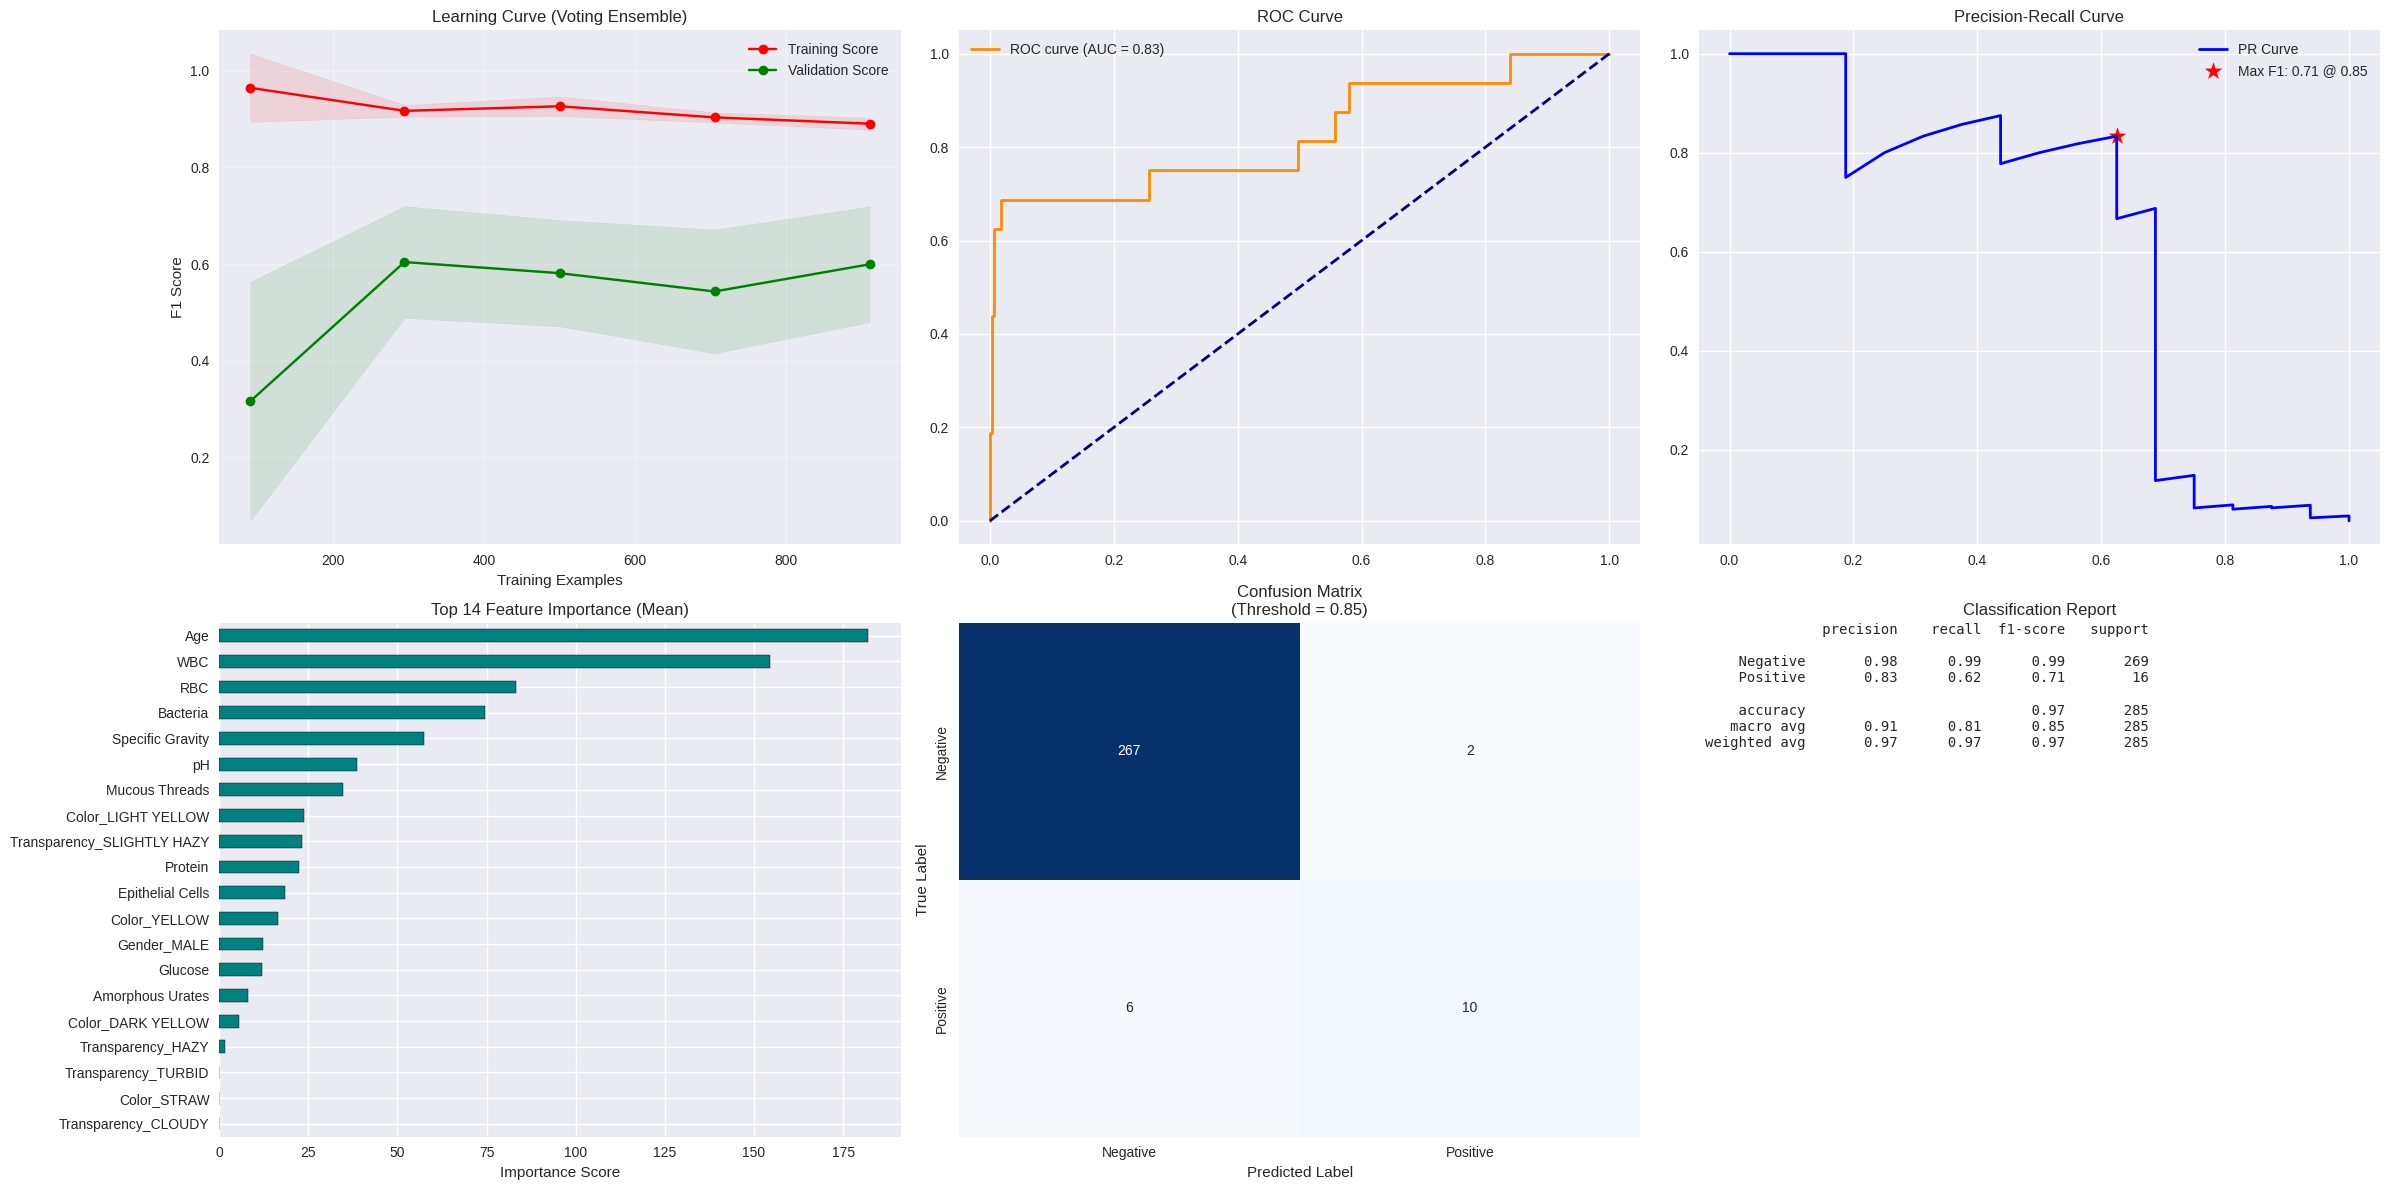


✅ OPTIMAL THRESHOLD FOUND: 0.8518

📊 CLASSIFICATION REPORT (At Optimal Threshold)
              precision    recall  f1-score   support

    Negative       0.98      0.99      0.99       269
    Positive       0.83      0.62      0.71        16

    accuracy                           0.97       285
   macro avg       0.91      0.81      0.85       285
weighted avg       0.97      0.97      0.97       285



In [ ]:

def evaluate_model_comprehensive(model, X_train, y_train, X_test, y_test, model_name="Voting Ensemble"):
    fig, axes = plt.subplots(2, 3, figsize=(24, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # --- Panel 1: LEARNING CURVE ---
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    axes[0,0].plot(train_sizes, train_mean, 'o-', color="r", label="Training Score")
    axes[0,0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    axes[0,0].plot(train_sizes, val_mean, 'o-', color="g", label="Validation Score")
    axes[0,0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")
    axes[0,0].set_title(f"Learning Curve ({model_name})")
    axes[0,0].set_xlabel("Training Examples")
    axes[0,0].set_ylabel("F1 Score")
    axes[0,0].legend(loc="best")
    axes[0,0].grid(True, alpha=0.3)

    # --- Panel 2: ROC CURVE ---
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]
    else:
        y_probs = model.decision_function(X_test)

    fpr, tpr, thresholds_roc = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0,1].set_title("ROC Curve")
    axes[0,1].legend()

    # --- Panel 3: PRECISION-RECALL CURVE ---
    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    ix_f1 = np.nanargmax(f1_scores)
    best_f1_thresh = thresholds_pr[ix_f1]

    axes[0,2].plot(recall, precision, color='blue', lw=2, label='PR Curve')
    axes[0,2].scatter(recall[ix_f1], precision[ix_f1], marker='*', color='red', s=150,
                      label=f'Max F1: {f1_scores[ix_f1]:.2f} @ {best_f1_thresh:.2f}')
    axes[0,2].set_title("Precision-Recall Curve")
    axes[0,2].legend()

    # --- Panel 4: FEATURE IMPORTANCE ---
    importances = None
    if hasattr(model, 'estimators_'):
        est_importances = []
        for est in model.estimators_:
            if hasattr(est, 'feature_importances_'):
                est_importances.append(est.feature_importances_)
        if est_importances:
            importances = np.mean(est_importances, axis=0)
    elif hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_

    if importances is not None:
        if hasattr(X_train, 'columns'):
            features = X_train.columns
        else:
            features = [f'Feature {i}' for i in range(X_train.shape[1])]

        feat_imp_series = pd.Series(importances, index=features).sort_values(ascending=True)
        feat_imp_series.tail(20).plot(kind='barh', ax=axes[1,0], color='teal', edgecolor='black')
        axes[1,0].set_title(f"Top 14 Feature Importance (Mean)")
        axes[1,0].set_xlabel("Importance Score")
    else:
        axes[1,0].text(0.5, 0.5, 'Feature Importance Not Available',
                       horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes)

    y_pred_opt = (y_probs >= best_f1_thresh).astype(int)

    # --- Panel 5: VISUAL CONFUSION MATRIX ---
    cm = confusion_matrix(y_test, y_pred_opt)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1], cbar=False,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    axes[1,1].set_title(f"Confusion Matrix\n(Threshold = {best_f1_thresh:.2f})")
    axes[1,1].set_ylabel("True Label")
    axes[1,1].set_xlabel("Predicted Label")

    # --- Panel 6: CLASSIFICATION REPORT ---
    report = classification_report(y_test, y_pred_opt, target_names=['Negative', 'Positive'])
    axes[1,2].text(0.01, 1.0, report, fontsize=10, fontfamily='monospace', va='top')
    axes[1,2].axis('off')
    axes[1,2].set_title("Classification Report")

    plt.tight_layout()
    plt.show()

    # --- PRINT METRICS ---
    print(f"\n✅ OPTIMAL THRESHOLD FOUND: {best_f1_thresh:.4f}")
    print("\n" + "="*60)
    print("📊 CLASSIFICATION REPORT (At Optimal Threshold)")
    print("="*60)
    print(report)

evaluate_model_comprehensive(ensemble_fixed, X_train, y_train, X_test, y_test)

# **5. Rule-Based Expert System (Non-UTI Conditions)**

In [ ]:
def calculate_dynamic_probabilities(row_dict):
    gender = str(row_dict.get('Gender', 'FEMALE')).upper()

    conditions = {
        'Kidney_Disease':      {'score': 0, 'ceiling': 80},
        'Diabetes':            {'score': 0, 'ceiling': 50},
        'Liver_Issues':        {'score': 0, 'ceiling': 40},
        'Dehydration':         {'score': 0, 'ceiling': 50},
        'Hematuria':           {'score': 0, 'ceiling': 50},
        'Sample_Contamination':{'score': 0, 'ceiling': 40}
    }

    reasons = {k: [] for k in conditions.keys()}
    reasons['Normal'] = []

    age = row_dict.get('Age', 0)
    prot = row_dict.get('Protein', 0)
    gluc = row_dict.get('Glucose', 0)
    rbc = row_dict.get('RBC', 0)
    wbc = row_dict.get('WBC', 0)
    ph = row_dict.get('pH', 0)
    sg = row_dict.get('Specific Gravity', 0)
    epith = row_dict.get('Epithelial Cells', 0)
    mucous = row_dict.get('Mucous Threads', 0)
    urates = row_dict.get('Amorphous Urates', 0)
    bacteria = row_dict.get('Bacteria', 0)
    color = str(row_dict.get('Color', '')).upper()
    transparency = str(row_dict.get('Transparency', '')).upper()

    # --- KIDNEY DISEASE ---
    if wbc >= 2:
        score = min(wbc * 3, 30)
        conditions['Kidney_Disease']['score'] += score

        if wbc >= 10:
            reasons['Kidney_Disease'].append(f"Very high WBC ({wbc}) suggests severe infection (possible pyelonephritis).")
        else:
            reasons['Kidney_Disease'].append(f"Elevated WBC ({wbc}) indicates inflammation/infection.")

        if gender == 'MALE' and wbc >= 4:
            conditions['Kidney_Disease']['score'] += 10
            reasons['Kidney_Disease'].append("Significant pyuria in male warrants closer evaluation.")

    if prot >= 1:
        score = prot * 12
        conditions['Kidney_Disease']['score'] += score
        reasons['Kidney_Disease'].append(f"Proteinuria ({prot}+) suggests glomerular dysfunction.")
        if prot >= 3:
            reasons['Kidney_Disease'].append("Severe proteinuria (≥3+) indicates significant renal damage.")

    # Bacteria
    if bacteria >= 2:
        conditions['Kidney_Disease']['score'] += 12
        reasons['Kidney_Disease'].append(f"Bacteriuria present (level {bacteria}).")
        if wbc >= 2 and bacteria >= 3:
            conditions['Kidney_Disease']['score'] += 12
            reasons['Kidney_Disease'].append("Combined bacteriuria + pyuria confirms active infection.")

    # Age
    if age >= 50:
        age_score = min((age - 50) * 0.3, 8)
        conditions['Kidney_Disease']['score'] += age_score
        if age >= 65:
            reasons['Kidney_Disease'].append(f"Advanced age ({int(age)}) increases kidney disease risk.")

    # --- DIABETES ---
    if gluc >= 1:
        score = gluc * 20
        conditions['Diabetes']['score'] += score
        reasons['Diabetes'].append(f"Glycosuria detected ({gluc}+).")
        if ph > 0 and ph < 6.0:
            conditions['Diabetes']['score'] += 10
            reasons['Diabetes'].append(f"Low pH ({ph:.1f}) with glucose may indicate ketoacidosis.")

    # --- HEMATURIA ---
    if rbc > 2:
        score = min(rbc * 3, 50)
        conditions['Hematuria']['score'] += score
        reasons['Hematuria'].append(f"Microscopic hematuria detected (RBC: {rbc}).")

        if rbc > 15:
            conditions['Kidney_Disease']['score'] += 15
            reasons['Kidney_Disease'].append("Severe hematuria suggests renal injury, stones, or malignancy.")

    # Check visible blood in urine color
    if color in ['RED', 'LIGHT RED', 'REDDISH', 'REDDISH YELLOW', 'DARK RED']:
        conditions['Hematuria']['score'] += 25
        reasons['Hematuria'].append(f"Visible hematuria (color: {color}).")
        # Cross-link to kidney disease
        if rbc <= 2:
            conditions['Kidney_Disease']['score'] += 8
            reasons['Kidney_Disease'].append("Visible blood with low RBC count suggests intermittent bleeding.")

    # --- LIVER ISSUES ---
    if color in ['BROWN', 'AMBER', 'DARK YELLOW']:
        conditions['Liver_Issues']['score'] += 30
        reasons['Liver_Issues'].append(f"Abnormal color ({color}) suggests bilirubin presence.")

    # --- DEHYDRATION---
    if sg >= 1.025:
        # Check glucose first
        if gluc >= 2:
             reasons['Dehydration'].append(f"Note: High Specific Gravity ({sg:.3f}) may be caused by Glucose, not just dehydration.")
             score = 10
        else:
            if sg >= 1.035:
                score = 40  # Severe dehydration
                reasons['Dehydration'].append(f"Very high specific gravity ({sg:.3f}) indicates severe dehydration.")
            elif sg >= 1.030:
                score = 28
                reasons['Dehydration'].append(f"High specific gravity ({sg:.3f}) indicates significant dehydration.")
            else:
                score = 18
                reasons['Dehydration'].append(f"Elevated specific gravity ({sg:.3f}) suggests mild dehydration.")

        conditions['Dehydration']['score'] += score

    # Age factor for dehydration
    if age >= 60 and conditions['Dehydration']['score'] > 0:
        conditions['Dehydration']['score'] += 8
        reasons['Dehydration'].append(f"Older age ({int(age)}) increases dehydration risk.")

    if urates >= 3:
        conditions['Dehydration']['score'] += 10
        reasons['Dehydration'].append("Amorphous urates support concentrated urine finding.")

    # --- KIDNEY STONES ---
    if ph >= 8.0:
        conditions['Kidney_Disease']['score'] += 12
        reasons['Kidney_Disease'].append(f"Alkaline pH ({ph:.1f}) increases stone formation risk.")

    if transparency in ['TURBID', 'CLOUDY']:
        if bacteria < 2 and wbc < 2:
            conditions['Kidney_Disease']['score'] += 8
            reasons['Kidney_Disease'].append("Turbidity without infection suggests crystals/stones.")

    # --- SAMPLE CONTAMINATION ---
    contamination_detected = False
    if epith >= 3 or mucous >= 3:
        contamination_score = (epith * 5) + (mucous * 3)

        if gender == 'FEMALE':
            contamination_score *= 0.75
            reasons['Sample_Contamination'].append("Elevated epithelial cells (common in female samples, but high).")
        else:
            reasons['Sample_Contamination'].append("High epithelial cells in male sample indicates contamination.")

        conditions['Sample_Contamination']['score'] += contamination_score
        contamination_detected = True

        # Only flag protein if contamination is severe
        if prot >= 1 and epith >= 5:
            reasons['Kidney_Disease'].append("Note: Protein may be inflated by contamination. Recommend repeat.")

    # --- CALCULATE PROBABILITIES ---
    final_probabilities = {}
    for cond, data in conditions.items():
        if data['ceiling'] > 0:
            raw_prob = (data['score'] / data['ceiling']) * 100
            prob = min(round(raw_prob, 1), 99.9)
            if prob > 15:
                final_probabilities[cond] = prob

    # IMPROVED NORMAL CALCULATION
    normal_indicators = 0
    normal_total = 5

    if wbc < 2: normal_indicators += 1
    if rbc < 3: normal_indicators += 1
    if prot < 1: normal_indicators += 1
    if bacteria < 2: normal_indicators += 1
    if 5.0 <= ph <= 7.5: normal_indicators += 1

    normal_prob = round((normal_indicators / normal_total) * 100, 1)

    # Only add Normal if most parameters are actually normal
    if normal_prob >= 60:
        final_probabilities['Normal'] = normal_prob
        primary_condition = 'Normal'
        reasons['Normal'].append(f"Most urinalysis parameters within normal range ({normal_indicators}/{normal_total}).")
    else:
        medical_risks = {k:v for k,v in final_probabilities.items()
                        if k not in ['Sample_Contamination', 'Normal']}
        if medical_risks:
            primary_condition = max(medical_risks, key=medical_risks.get)
        else:
            primary_condition = 'Sample_Contamination' if contamination_detected else 'Indeterminate'

    # --- ADVISORY ---
    advisory = "Findings: "
    if primary_condition == 'Normal':
        advisory += "Urinalysis parameters within normal limits. "
    else:
        high_risks = [k for k, v in final_probabilities.items()
                     if v > 50 and k not in ['Normal', 'Sample_Contamination']]
        if high_risks:
            advisory += f"Strong indicators for: {', '.join(high_risks)}. "
        else:
            advisory += f"Possible {primary_condition}. "

    if final_probabilities.get('Sample_Contamination', 0) > 40:
        advisory += "⚠ WARNING: Sample quality concern. Recommend repeat collection with proper technique. "

    return {
        'probabilities': final_probabilities,
        'reasons': reasons,
        'primary_condition': primary_condition,
        'advisory': advisory
    }

# **6. Advisory System for UTI**

In [ ]:
def generate_uti_advisory(prediction, probability, row_data):
    wbc_val = row_data.get('WBC', 0)
    rbc_val = row_data.get('RBC', 0)
    protein_val = row_data.get('Protein', 0)
    bacteria_val = row_data.get('Bacteria', 0)
    color = str(row_data.get('Color', '')).upper()
    transparency = str(row_data.get('Transparency', '')).upper()

    uti_indicators = 0
    indicator_details = []

    if wbc_val >= 5:
        uti_indicators += 2
        indicator_details.append(f"Elevated WBC ({wbc_val})")
    elif wbc_val >= 2:
        uti_indicators += 1
        indicator_details.append(f"Mild WBC elevation ({wbc_val})")

    if bacteria_val >= 3:
        uti_indicators += 2
        indicator_details.append(f"Significant bacteriuria ({bacteria_val})")
    elif bacteria_val >= 2:
        uti_indicators += 1
        indicator_details.append(f"Bacteria present ({bacteria_val})")

    if rbc_val >= 5:
        uti_indicators += 1
        indicator_details.append(f"Hematuria ({rbc_val} RBC)")

    if protein_val >= 1:
        uti_indicators += 1
        indicator_details.append(f"Proteinuria ({protein_val}+)")

    if transparency in ['TURBID', 'CLOUDY']:
        uti_indicators += 1
        indicator_details.append("Turbid appearance")

    conf_pct = probability * 100
    advisory = {
        "status": "",
        "confidence": f"{conf_pct:.1f}%",
        "severity": "",
        "recommendation": "",
        "supporting_evidence": ", ".join(indicator_details) if indicator_details else "Limited"
    }

    if prediction == 1:
        advisory['status'] = "POSITIVE FOR UTI"

        if conf_pct > 90:
            advisory['severity'] = "High Confidence"
            action = "Immediate medical consultation recommended."
        elif conf_pct > 70:
            advisory['severity'] = "Moderate Confidence"
            action = "Medical consultation advised within 24-48 hours."
        else:
            advisory['severity'] = "Low Confidence (Borderline)"
            action = "Clinical correlation needed. Monitor symptoms."


        if uti_indicators >= 4:
            advisory['recommendation'] = f"{action} Strong laboratory evidence (multiple abnormal findings). Urine culture recommended."
        elif uti_indicators >= 2:
            advisory['recommendation'] = f"{action} Moderate laboratory support. Consider urine culture if symptomatic."
        else:
            advisory['recommendation'] = f"{action} Limited supporting evidence - result may be false positive. Clinical symptoms are critical for diagnosis."

    else:
        advisory['status'] = "NEGATIVE FOR UTI"

        if conf_pct < 10:
            advisory['severity'] = "High Confidence - Normal"
            advisory['recommendation'] = "No evidence of UTI. All parameters within normal limits."
        elif conf_pct < 30:
            advisory['severity'] = "Low UTI Risk"
            advisory['recommendation'] = "UTI unlikely based on urinalysis. Maintain hydration."
        elif conf_pct < 50:
            advisory['severity'] = "Borderline"
            advisory['recommendation'] = "Some abnormal findings present but below UTI threshold. Monitor for symptom development."
        else:
            advisory['severity'] = "Indeterminate"
            advisory['recommendation'] = "Conflicting results. If symptomatic, consider repeat urinalysis or urine culture."

    return advisory

# **7. Simulation & Testing**

In [ ]:
def parse_range(value):
    if pd.isna(value): return 0.0
    val_str = str(value).upper().strip()
    if 'LOADED' in val_str or 'TNTC' in val_str: return 100.0
    if 'NONE' in val_str: return 0.0
    if '-' in val_str:
        try:
            parts = val_str.split('-')
            return (float(parts[0]) + float(parts[1])) / 2
        except:
            return 0.0
    try:
        return float(val_str)
    except:
        return 0.0

def test_hybrid_system(ml_model, train_cols):
    """
    Tests the system using the currently trained ML model and rule-based functions.
    Fixes the TypeError by passing processed (numeric) data to advisory functions.
    """


    quantity_map = {
        'NONE SEEN': 0, 'RARE': 1, 'OCCASIONAL': 2, 'FEW': 3,
        'MODERATE': 4, 'PLENTY': 5, 'LOADED': 6, 'TNTC': 7,
        'NONE': 0, 'ABSENT': 0
    }

    chem_map = {
        'NEGATIVE': 0, 'TRACE': 0.5, '1+': 1, '2+': 2, '3+': 3, '4+': 4
    }


    patients = [
        {
            'name': 'Patient A (Classic UTI)',
            'data': {
                'Age': 25, 'Gender': 'FEMALE', 'Color': 'TURBID', 'Transparency': 'CLOUDY',
                'Glucose': 'NEGATIVE', 'Protein': 'TRACE', 'pH': 6.5, 'Specific Gravity': 1.015,
                'WBC': '20-25', 'RBC': '0-2', 'Epithelial Cells': 'MODERATE',
                'Mucous Threads': 'FEW', 'Amorphous Urates': 'NONE', 'Bacteria': 'MODERATE'
            }
        },
        {
            'name': 'Patient B (Kidney Risk + Hematuria)',
            'data': {
                'Age': 55, 'Gender': 'MALE', 'Color': 'RED', 'Transparency': 'HAZY',
                'Glucose': 'NEGATIVE', 'Protein': '3+', 'pH': 6.0, 'Specific Gravity': 1.010,
                'WBC': '0-2', 'RBC': '50-60', 'Epithelial Cells': 'FEW',
                'Mucous Threads': 'NONE', 'Amorphous Urates': 'NONE', 'Bacteria': 'NONE'
            }
        },
         {
            'name': 'Patient C (Healthy)',
            'data': {
                'Age': 22, 'Gender': 'FEMALE', 'Color': 'LIGHT YELLOW', 'Transparency': 'CLEAR',
                'Glucose': 'NEGATIVE', 'Protein': 'NEGATIVE', 'pH': 6.0, 'Specific Gravity': 1.015,
                'WBC': '0-2', 'RBC': '0-2', 'Epithelial Cells': 'RARE',
                'Mucous Threads': 'RARE', 'Amorphous Urates': 'NONE', 'Bacteria': 'NONE'
            }
        }
    ]

    for p in patients:
        print(f"\n{'='*60}")
        print(f"🧪 TESTING: {p['name']}")
        print(f"{'='*60}")

        p_data = p['data']


        processed_data = p_data.copy()

        processed_data['WBC'] = parse_range(p_data['WBC'])
        processed_data['RBC'] = parse_range(p_data['RBC'])

        processed_data['Protein'] = chem_map.get(str(p_data['Protein']).upper(), 0)
        processed_data['Glucose'] = chem_map.get(str(p_data['Glucose']).upper(), 0)


        for col in ['Epithelial Cells', 'Mucous Threads', 'Amorphous Urates', 'Bacteria']:
            val = str(p_data.get(col, 'NONE')).upper()
            processed_data[col] = quantity_map.get(val, 0)


        input_df = pd.DataFrame(0, index=[0], columns=train_cols)


        input_df['Age'] = processed_data['Age']
        input_df['pH'] = processed_data['pH']
        input_df['Specific Gravity'] = processed_data['Specific Gravity']


        input_df['WBC'] = processed_data['WBC']
        input_df['RBC'] = processed_data['RBC']
        input_df['Protein'] = processed_data['Protein']
        input_df['Glucose'] = processed_data['Glucose']
        for col in ['Epithelial Cells', 'Mucous Threads', 'Amorphous Urates', 'Bacteria']:
            input_df[col] = processed_data[col]


        for col, val in [('Gender', p_data['Gender']), ('Color', p_data['Color']), ('Transparency', p_data['Transparency'])]:
            col_name = f"{col}_{str(val).upper()}"
            if col_name in input_df.columns:
                input_df[col_name] = 1


        try:
            uti_prob = ml_model.predict_proba(input_df)[0][1]
            uti_pred = 1 if uti_prob > 0.30 else 0
        except Exception as e:
            print(f"ML Prediction Error: {e}")
            uti_prob = 0
            uti_pred = 0


        if 'generate_uti_advisory' in globals():
            uti_report = generate_uti_advisory(uti_pred, uti_prob, processed_data)
        else:
            uti_report = {'status': 'UNKNOWN', 'confidence': 'N/A', 'recommendation': 'Function Missing'}


        if 'calculate_dynamic_probabilities' in globals():
            rule_report = calculate_dynamic_probabilities(processed_data)
        else:
            rule_report = {'probabilities': {}, 'primary_condition': 'None', 'advisory': 'Function Missing', 'reasons': {}}

        print(f"🔹 ML MODEL (UTI STATUS): {uti_report.get('status', 'N/A')}")
        print(f"   Confidence: {uti_report.get('confidence', 'N/A')}")
        print(f"   Advice:     {uti_report.get('recommendation', 'N/A')}")

        print(f"\n🔹 RULE-BASED (FULL DISEASE BREAKDOWN):")
        sorted_probs = sorted(rule_report.get('probabilities', {}).items(), key=lambda x: x[1], reverse=True)

        if not sorted_probs:
            print("   No significant rule-based findings.")

        for disease, prob in sorted_probs:
            if disease == rule_report.get('primary_condition'):
                print(f"   ➤ {disease}: {prob}% (PRIMARY)")
            else:
                print(f"     {disease}: {prob}%")

        print(f"\n   Main Advisory: {rule_report.get('advisory', 'N/A')}")

        primary_cond = rule_report.get('primary_condition')
        reasons = rule_report.get('reasons', {})
        if primary_cond and reasons.get(primary_cond):
             print(f"   Primary Reason: {reasons[primary_cond][0]}")

if 'ensemble_fixed' in globals() and 'X_train' in globals():
    test_hybrid_system(ensemble_fixed, X_train.columns)
else:
    print("Please ensure 'ensemble_fixed' (model) and 'X_train' (data) are defined.")


🧪 TESTING: Patient A (Classic UTI)
🔹 ML MODEL (UTI STATUS): POSITIVE FOR UTI
   Confidence: 96.1%
   Advice:     Immediate medical consultation recommended. Strong laboratory evidence (multiple abnormal findings). Urine culture recommended.

🔹 RULE-BASED (FULL DISEASE BREAKDOWN):
     Kidney_Disease: 67.5%
   ➤ Normal: 60.0% (PRIMARY)
     Sample_Contamination: 54.4%

   Main Advisory: Findings: Urinalysis parameters within normal limits. ⚠ WARNING: Sample quality concern. Recommend repeat collection with proper technique. 
   Primary Reason: Most urinalysis parameters within normal range (3/5).

🧪 TESTING: Patient B (Kidney Risk + Hematuria)
🔹 ML MODEL (UTI STATUS): NEGATIVE FOR UTI
   Confidence: 15.0%
   Advice:     UTI unlikely based on urinalysis. Maintain hydration.

🔹 RULE-BASED (FULL DISEASE BREAKDOWN):
     Hematuria: 99.9%
     Kidney_Disease: 65.6%
   ➤ Normal: 60.0% (PRIMARY)
     Sample_Contamination: 37.5%

   Main Advisory: Findings: Urinalysis parameters within normal 

# **8. Save model**

In [ ]:
import joblib

joblib.dump(ensemble_fixed, 'uti_model.pkl')

joblib.dump(list(X_train.columns), 'model_columns.pkl')

joblib.dump(color_mode, 'color_mode.pkl')

optimal_threshold = 0.8518
joblib.dump(optimal_threshold, 'uti_threshold.pkl')

print("✅ SUCCESS! Please download these 4 files:")
print("1. uti_model.pkl")
print("2. model_columns.pkl")
print("3. color_mode.pkl")
print("4. uti_threshold.pkl")

✅ SUCCESS! Please download these 4 files:
1. uti_model.pkl
2. model_columns.pkl
3. color_mode.pkl
4. uti_threshold.pkl
